In [10]:
"""
looking at trends in AUROC as a function of X
-path length
-physical distance

adapted from: allenadultmouseISH/pathlen_eighteen.ipynb

Shaina Lu
Gillis & Zador Labs
June 2020
"""

'\nlooking at trends in AUROC as a function of X\n-path length\n-physical distance\n\nadapted from: allenadultmouseISH/pathlen_eighteen.ipynb\n\nShaina Lu\nGillis & Zador Labs\nJune 2020\n'

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sp

In [3]:
#function for matplotlib formatting
def set_style():
    plt.style.use(['seaborn-white','seaborn-notebook'])
    plt.rcParams['figure.figsize'] = [6,4]
    plt.rcParams['axes.spines.top'] = False       #remove top line
    plt.rcParams['axes.spines.right'] = False     #remove right line
    plt.rcParams['axes.linewidth'] = 2.0          #set weight of axes
    plt.rcParams['axes.titlesize'] = 20           #set font size of title
    plt.rcParams['axes.labelsize'] = 18           #set font size of x,y labels
    plt.rcParams['axes.labelpad'] = 14            #space between labels and axes
    plt.rcParams['xtick.labelsize'] = 14          #set x label size
    plt.rcParams['ytick.labelsize'] = 14          #set y label size
    plt.rcParams['legend.fontsize'] = 16          #set legend font size
    
set_style()

# Read in Data

In [4]:
ALLEN_FILT_PATH = "/home/slu/spatial/data/ABAISH_filt_v6_avgdup.h5"
ONTOLOGY_PATH = "/data/slu/allen_adult_mouse_ISH/ontologyABA.csv"
ST_CANTIN_FILT_PATH = "/home/slu/spatial/data/cantin_ST_filt_v2.h5"
ABA_COORD_PATH = "/data/slu/allen_adult_mouse_ISH/voxelCoordinates.csv"

In [5]:
#ABA
ABAvoxmeta = pd.read_hdf(ALLEN_FILT_PATH, key='metabrain', mode='r')
ABAvox = pd.read_hdf(ALLEN_FILT_PATH, key='avgvoxbrain', mode='r')
ABApropont = pd.read_hdf(ALLEN_FILT_PATH, key='propontology', mode='r')
#geneIDName = pd.read_hdf(ALLEN_FILT_PATH, key='geneIDName', mode='r')	

#ST
STspotsmeta = pd.read_hdf(ST_CANTIN_FILT_PATH, key='STspotsmeta', mode='r')
STspots = pd.read_hdf(ST_CANTIN_FILT_PATH, key='STspots', mode='r')
STpropont = pd.read_hdf(ST_CANTIN_FILT_PATH, key='STpropont', mode='r')

#ontology
ontology = pd.read_csv(ONTOLOGY_PATH)
ontology = ontology.drop([ontology.columns[5], ontology.columns[6]], axis=1)
ontology = ontology.fillna(-1)  #make root's parent -1

#coordinates
allcoords = pd.read_csv(ABA_COORD_PATH)
voxcoords = allcoords[allcoords.index.isin(ABAvox.index)] #keep only those in filtered voxbrain

In [6]:
ALLBYALL_PATH = "/home/slu/spatial/data/cross_lasso/STtoABA_STtest_f1_0p1_051420.csv"
allbrainareas = pd.read_csv(ALLBYALL_PATH, sep=',').columns.values

# Calculate Path Length

In [8]:
def getpathlen(ontology, area1, area2):
    """take in two brain id's and determine the number of steps in brain structure hierarchy
       between the two areas"""
    #get all parents of both brain areas
    all1 = []
    all2 = []
    parent1 = area1
    parent2 = area2
    while parent1 != -1.0:
        parent1 = ontology.loc[ontology.id==parent1, 'parent'].item()
        all1.append(parent1)

    while parent2 != -1.0:
        parent2 = ontology.loc[ontology.id==parent2, 'parent'].item()
        all2.append(parent2)

    #find earliest shared brain area
    index1 = -1
    index2 = -1
    done = False
    for i in range(len(all1)):
        for j in range(len(all2)):
            if all1[i] == all2[j]:
                index1 = i
                index2 = j
                done = True
                break
        if done == True:
            break

    return index1+index2

In [18]:
#get all path lengths
allpathlen = pd.DataFrame(index=allbrainareas, columns=allbrainareas)

In [20]:
#this is slow
for i in range(allpathlen.shape[0]):
    for j in range(i+1, allpathlen.shape[1]): #upper triangular
        currlen = getpathlen(ontology,int(allbrainareas[i]),int(allbrainareas[j]))
        allpathlen.iloc[i,j] = currlen
    #break

/home/slu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: `item` has been deprecated and will be removed in a future version
  # Remove the CWD from sys.path while we load stuff.
/home/slu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: `item` has been deprecated and will be removed in a future version
  


In [21]:
#save for future speed
allpathlen.to_csv("/home/slu/spatial/data/pathlen_0611.csv", sep=',', header=True, index=False)

__start here after path len already calculated__

In [19]:
#after running above, in future start here
allpathlen = pd.read_csv("/home/slu/spatial/data/pathlen_0611.csv", sep=',')

In [20]:
#add 2 to all pathlengths
allpathlen = allpathlen + 2

In [21]:
def pathlenviolin(aurocdata, ylabel, savefile):
    sns.violinplot(x=allpathlen.values[np.triu_indices_from(allpathlen.values, k=1)],\
                   y=aurocdata.values[np.triu_indices_from(aurocdata.values, k=1)])
    plt.xlabel("path length")
    plt.ylabel(ylabel)
    
    if savefile != False:
        plt.savefig(savefile, bbox_inches='tight')
    plt.show()

In [22]:
def pathlenmeanplt(aurocdata, ylabel, savefile):
    sns.pointplot(x=allpathlen.values[np.triu_indices_from(allpathlen.values, k=1)],\
                   y=aurocdata.values[np.triu_indices_from(aurocdata.values, k=1)], ci='sd')
    plt.xlabel("path length")
    plt.ylabel(ylabel)
    plt.ylim([0.45, 1.0])
    
    if savefile != False:
        plt.savefig(savefile, bbox_inches='tight')
    plt.show()

# Calculate physical distance
Use workflow from before: find minimum distance in one hemisphere

In [22]:
#use 30 as rough cutoff for midline
voxcoords_onehemi = voxcoords.loc[voxcoords.zcord < 30, :]

In [23]:
#calculate pairwise distance of all voxels
allvoxdist = sp.spatial.distance.pdist(voxcoords_onehemi.values,metric='euclidean')
allvoxdist = sp.spatial.distance.squareform(allvoxdist)

In [24]:
#covert to pandas
allvoxdists = pd.DataFrame(allvoxdist, index=voxcoords_onehemi.index, columns=voxcoords_onehemi.index)

In [32]:
#first just subset for only those voxels that appear in any of the brain areas
ABApropont_sub = ABApropont.loc[:,allbrainareas]
rowsums = ABApropont_sub.sum(axis=1)
keep = rowsums[rowsums > 0]
allvoxdist_sub = allvoxdists.loc[keep.index, keep.index]
ABApropont_sub = ABApropont.loc[keep.index, allbrainareas]

In [35]:
#get brain wise minimum distances
ABAdists = pd.DataFrame(index=allbrainareas, columns=allbrainareas)

In [36]:
for i in range(len(allbrainareas)):
    for j in range(i+1, len(allbrainareas)): #upper triangular
        #get all voxels belonging to current brain areas
        voxels1 = ABApropont_sub.loc[ABApropont_sub[allbrainareas[i]] == 1].index
        voxels2 = ABApropont_sub.loc[ABApropont_sub[allbrainareas[j]] == 1].index
        mindist = allvoxdist_sub.loc[voxels1, voxels2].min().min()
        ABAdists.iloc[i,j] = mindist

In [37]:
ABAdists.to_csv("/home/slu/spatial/data/ABAmindist_0611.csv", sep=',', header=True, index=False)

__start here after euclidean distance already calculated__

In [7]:
#after running above, in future start here
ABAdists = pd.read_csv("/home/slu/spatial/data/ABAmindist_0611.csv", sep=',')

In [8]:
def physdistplt(aurocdata, ylabel, savefile):
    g = sns.jointplot(ABAdists.values[np.triu_indices_from(ABAdists.values, k=1)], \
                     aurocdata.values[np.triu_indices_from(aurocdata.values, k=1)], \
                     kind='hex')
    g.set_axis_labels("euclidean distance between brain areas", ylabel)
    
    if savefile != False:
        plt.savefig(savefile, bbox_inches='tight')
    plt.show()

In [9]:
def convphysdistplt(aurocdata, ylabel, savefile):
    #define 'sliding window' as a uniform dist
    uniform = [1/1000] * 1000
    #sort both lists by distance
    eucdists = ABAdists.values[np.triu_indices_from(ABAdists.values, k=1)]
    aurocdata = aurocdata.values[np.triu_indices_from(aurocdata.values, k=1)]
    eucdists = sorted(eucdists)
    aurocdata = [x for y, x in sorted(zip(eucdists,aurocdata))]
    #convolve
    convroc = np.convolve(aurocdata, uniform, mode='same')
    
    plt.scatter(eucdists, convroc, s=0.1, rasterized=True)
    plt.xlabel("euclidean distance between brain areas")
    plt.ylabel(ylabel)
    plt.ylim([0,1.0])
    
    if savefile != False:
        plt.savefig(savefile, bbox_inches='tight')
    plt.show()

In [76]:
def binnedphysdistplt(aurocdata, ylabel, numbins, savefile):
    #sort both lists by distance
    eucdists = ABAdists.values[np.triu_indices_from(ABAdists.values, k=1)]
    aurocdata = aurocdata.values[np.triu_indices_from(aurocdata.values, k=1)]
    eucdists = sorted(eucdists)
    aurocdata = [x for y, x in sorted(zip(eucdists,aurocdata))]
    
    #bin by equal #samples per bin
    binsize = len(eucdists)//numbins
    print(len(eucdists)%numbins)
    mean = []
    sd = []
    startindex = 0
    for i in range(numbins):
        if i == numbins-1: #last bin
            currint = aurocdata[startindex:len(aurocdata)]
        else:
            currint = aurocdata[startindex:startindex+binsize]
        
        mean.append(np.mean(currint))
        sd.append(np.std(currint))
        startindex = startindex+binsize
        
    #also get euclidean distance for x-axis
    diff = np.max(eucdists) - np.min(eucdists)
    diff/numbins
    
    plt.scatter(range(1,numbins+1), mean, rasterized=True)
    plt.errorbar(x=range(1,numbins+1), y=mean, yerr=sd)
    plt.xlabel("physical distance between brain areas\n(standardized rank of Euclidean distance)")
    plt.ylabel(ylabel)
    plt.ylim([0.5,1.07])
    
    if savefile != False:
        plt.savefig(savefile, bbox_inches='tight')
    plt.show()

# ST to ABA LASSO alpha = 0.1

In [58]:
STTRAIN_FILE = "/home/slu/spatial/data/cross_lasso/STtoABA_STtrain_f1_0p1_051420.csv"
STTEST_FILE = "/home/slu/spatial/data/cross_lasso/STtoABA_STtest_f1_0p1_051420.csv"
ABAALL_FILE = "/home/slu/spatial/data/cross_lasso/STtoABA_ABAall_f1_0p1_051420.csv"

In [59]:
trainST = pd.read_csv(STTRAIN_FILE, sep=',')
trainST = trainST.set_index(trainST.columns)

testST = pd.read_csv(STTEST_FILE, sep=',')
testST = testST.set_index(testST.columns)

allABA = pd.read_csv(ABAALL_FILE, sep=',')
allABA = allABA.set_index(allABA.columns)

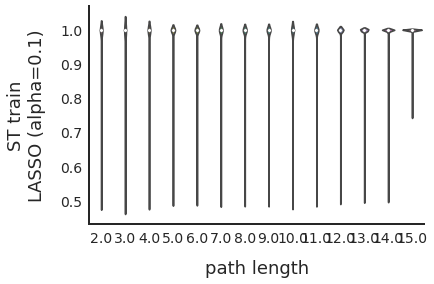

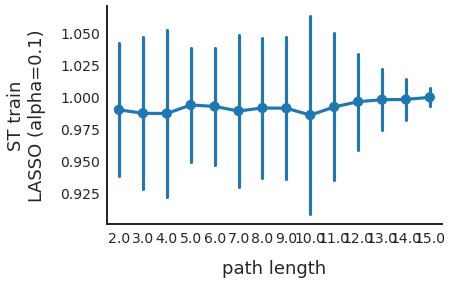

In [16]:
pathlenviolin(trainST, "ST train\nLASSO (alpha=0.1)", False)
pathlenmeanplt(trainST, "ST train\nLASSO (alpha=0.1)", False)

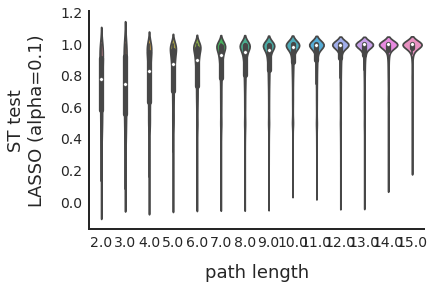

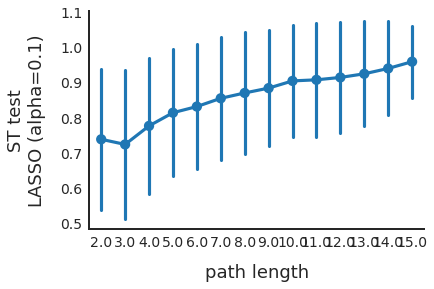

In [27]:
pathlenviolin(testST, "ST test\nLASSO (alpha=0.1)", False)
pathlenmeanplt(testST, "ST test\nLASSO (alpha=0.1)", False)

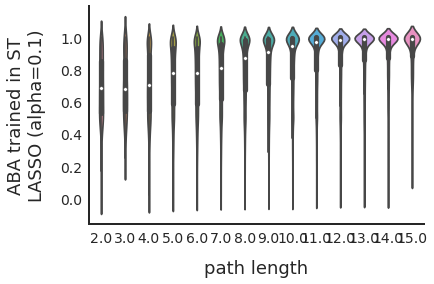

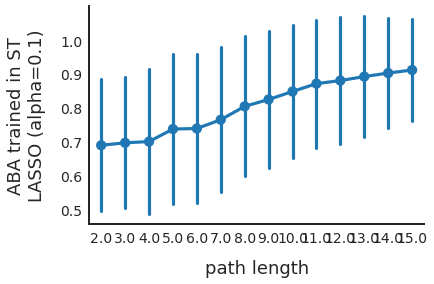

In [33]:
pathlenviolin(allABA, "ABA trained in ST\nLASSO (alpha=0.1)", False)
pathlenmeanplt(allABA, "ABA trained in ST\nLASSO (alpha=0.1)", "062220_3.pdf")

In [65]:
pathlen_upper = allpathlen.values[np.triu_indices_from(allpathlen.values, k=1)]
allABA_upper = allABA.values[np.triu_indices_from(allABA.values, k=1)]

In [66]:
#calculate difference in means between shortest and longest path length
print(allABA_upper[pathlen_upper==2].mean())
print(allABA_upper[pathlen_upper==2].std())

0.6894997807049434
0.19431217782476798


In [67]:
print(allABA_upper[pathlen_upper==np.max(pathlen_upper)].mean())
print(allABA_upper[pathlen_upper==np.max(pathlen_upper)].std())

0.9118065151580363
0.15148829518307563


In [68]:
#difference in means
allABA_upper[pathlen_upper==np.max(pathlen_upper)].mean() - allABA_upper[pathlen_upper==2].mean()

0.2223067344530929

__Explore inidvidual brain areas as examples__

In [148]:
filtareas = np.where(np.logical_and(allpathlen==2, allABA<=0.5))
areasx = np.array(list(allABA))[filtareas[0]]
areasy = np.array(list(allABA))[filtareas[1]]

In [149]:
print(len(areasx))
print(len(areasy))

134
134


In [150]:
#convert areas to int for ontology indexing
areasx = [int(i) for i in areasx]
areasy = [int(i) for i in areasy]

In [151]:
#has to be done this way because need to preserve order of pairs
xnames = pd.DataFrame(columns=list(ontology))
ynames = pd.DataFrame(columns=list(ontology))
for i in range(len(areasx)):
    xnames = xnames.append(ontology.loc[ontology.id==areasx[i], :])
    ynames = ynames.append(ontology.loc[ontology.id==areasy[i], :])

In [152]:
xnames.to_csv("temp.csv")

In [153]:
ynames.to_csv("temp.csv")

__physical distance__

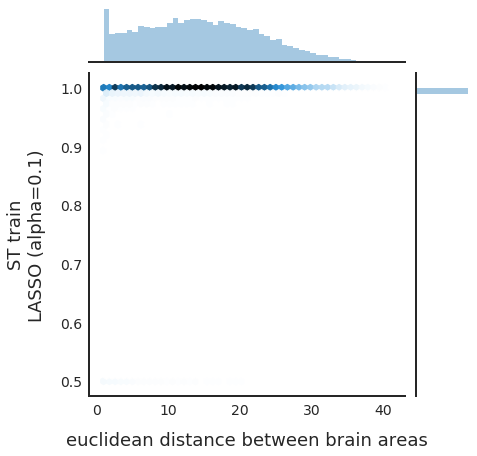

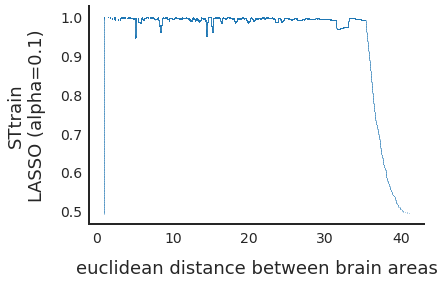

In [12]:
physdistplt(trainST, "ST train\nLASSO (alpha=0.1)", False)
convphysdistplt(trainST, "STtrain\nLASSO (alpha=0.1)", False)

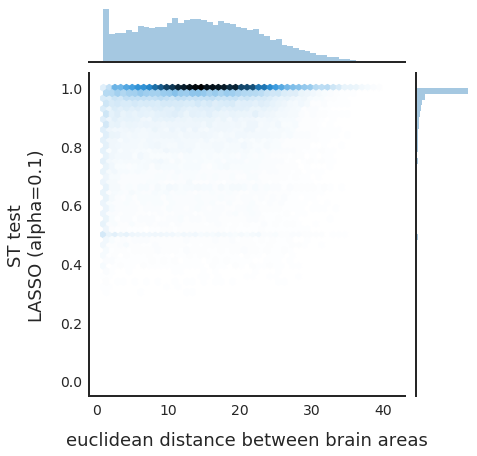

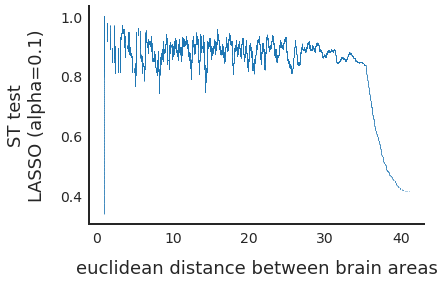

In [88]:
physdistplt(testST, "ST test\nLASSO (alpha=0.1)", False)
convphysdistplt(testST, "ST test\nLASSO (alpha=0.1)", False)

0


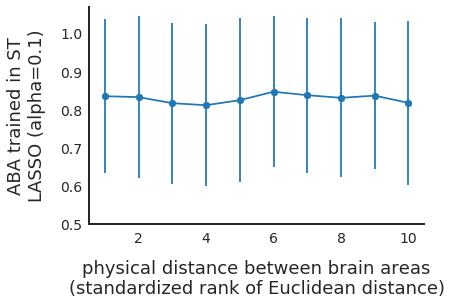

In [61]:
#physdistplt(allABA, "ABA trained in ST\nLASSO (alpha=0.1)", False)
#convphysdistplt(allABA, "ABA trained in ST\nLASSO (alpha=0.1)", False)
binnedphysdistplt(allABA, "ABA trained in ST\nLASSO (alpha=0.1)", 10, "080420_1.pdf")

play around w/ binning euclidean distance to match path len

In [193]:
mindist = ABAdists.min().min() #1
maxdist = ABAdists.max().max() #41.012

In [194]:
allABA.values[np.logical_and(ABAdists>=1, ABAdists<2)].mean()

0.7015953809556876

In [195]:
allABA.values[np.logical_and(ABAdists>maxdist-1, ABAdists<=maxdist)].mean()

0.6900732332033407

In [196]:
ABAdists_upper = ABAdists.values[np.triu_indices_from(ABAdists.values, k=1)]
allABA_upper = allABA.values[np.triu_indices_from(allABA.values, k=1)]

In [197]:
sp.stats.pearsonr(ABAdists_upper,allABA_upper)

(0.05604170195555056, 1.5010951745223932e-69)

# ST to ABA LASSO alpha = 0.05

In [65]:
STTRAIN_FILE = "/home/slu/spatial/data/cross_lasso/STtoABA_STtrain_f1_0p05_051720.csv"
STTEST_FILE = "/home/slu/spatial/data/cross_lasso/STtoABA_STtest_f1_0p05_051720.csv"
ABAALL_FILE = "/home/slu/spatial/data/cross_lasso/STtoABA_ABAall_f1_0p05_051720.csv"

In [66]:
trainST = pd.read_csv(STTRAIN_FILE, sep=',')
trainST = trainST.set_index(trainST.columns)

testST = pd.read_csv(STTEST_FILE, sep=',')
testST = testST.set_index(testST.columns)

allABA = pd.read_csv(ABAALL_FILE, sep=',')
allABA = allABA.set_index(allABA.columns)

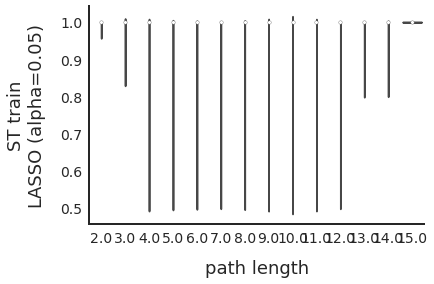

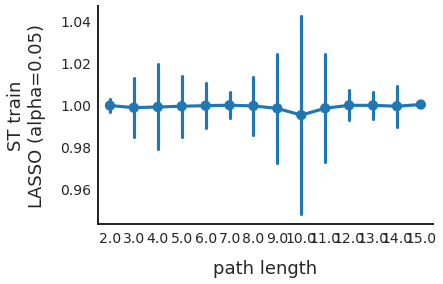

In [45]:
pathlenviolin(trainST, "ST train\nLASSO (alpha=0.05)", False)
pathlenmeanplt(trainST, "ST train\nLASSO (alpha=0.05)", False)

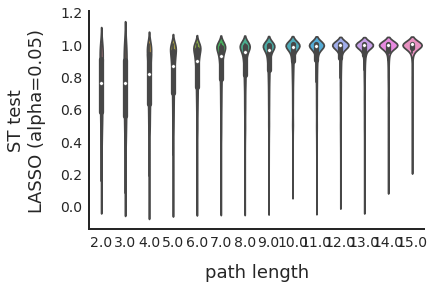

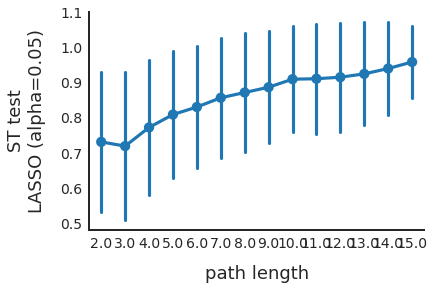

In [46]:
pathlenviolin(testST, "ST test\nLASSO (alpha=0.05)", False)
pathlenmeanplt(testST, "ST test\nLASSO (alpha=0.05)", False)

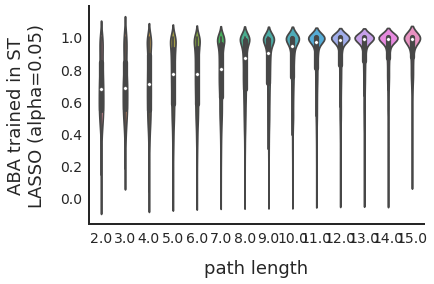

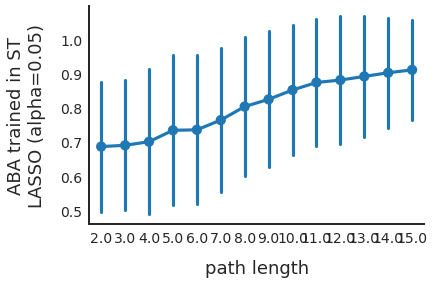

In [47]:
pathlenviolin(allABA, "ABA trained in ST\nLASSO (alpha=0.05)", False)
pathlenmeanplt(allABA, "ABA trained in ST\nLASSO (alpha=0.05)", "062220_5.pdf")

Explore inidvidual brain areas as examples

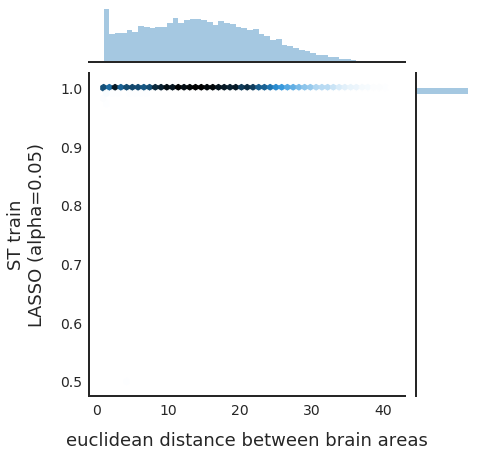

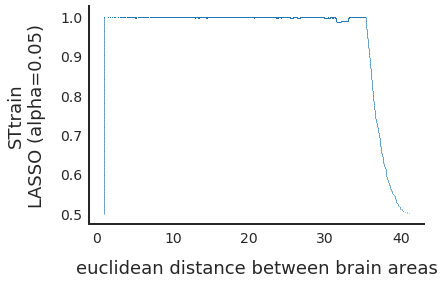

In [50]:
physdistplt(trainST, "ST train\nLASSO (alpha=0.05)", False)
convphysdistplt(trainST, "STtrain\nLASSO (alpha=0.05)", False)

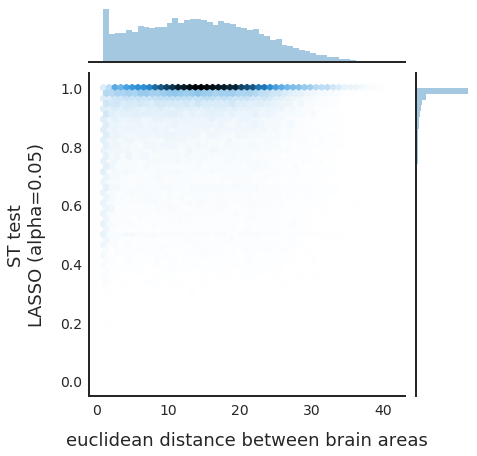

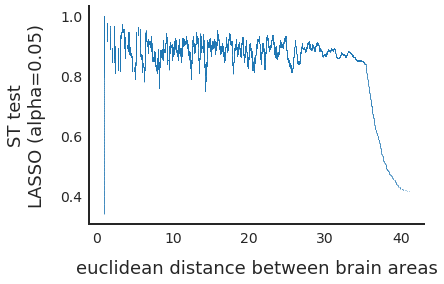

In [52]:
physdistplt(testST, "ST test\nLASSO (alpha=0.05)", False)
convphysdistplt(testST, "ST test\nLASSO (alpha=0.05)", False)

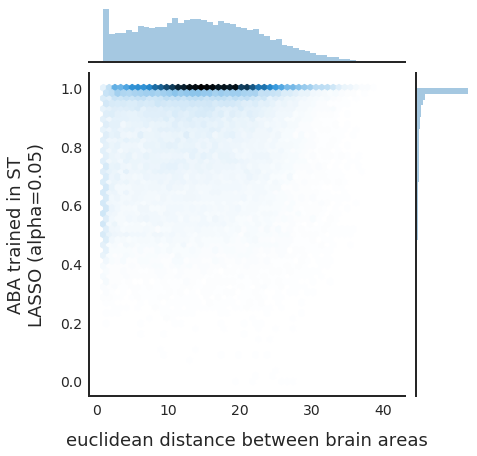

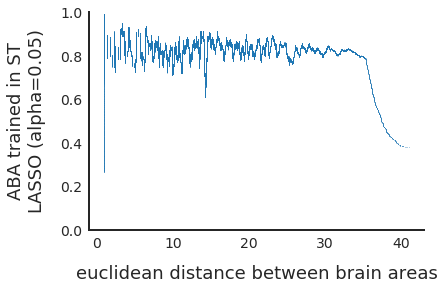

0


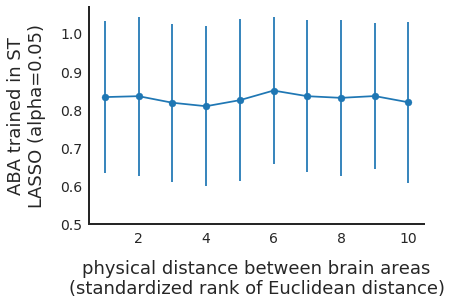

In [67]:
physdistplt(allABA, "ABA trained in ST\nLASSO (alpha=0.05)", False)
convphysdistplt(allABA, "ABA trained in ST\nLASSO (alpha=0.05)", False)
binnedphysdistplt(allABA, "ABA trained in ST\nLASSO (alpha=0.05)", 10, "080420_2.pdf")

# ST to ABA linear regression (alpha = 0)

In [68]:
STTRAIN_FILE = "/home/slu/spatial/data/cross_lasso/STtoABA_STtrain_f1_0_051520.csv"
STTEST_FILE = "/home/slu/spatial/data/cross_lasso/STtoABA_STtest_f1_0_051520.csv"
ABAALL_FILE = "/home/slu/spatial/data/cross_lasso/STtoABA_ABAall_f1_0_051520.csv"

In [69]:
trainST = pd.read_csv(STTRAIN_FILE, sep=',')
trainST = trainST.set_index(trainST.columns)

testST = pd.read_csv(STTEST_FILE, sep=',')
testST = testST.set_index(testST.columns)

allABA = pd.read_csv(ABAALL_FILE, sep=',')
allABA = allABA.set_index(allABA.columns)

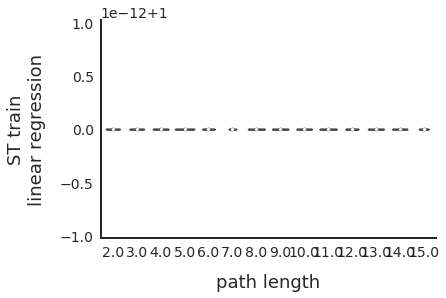

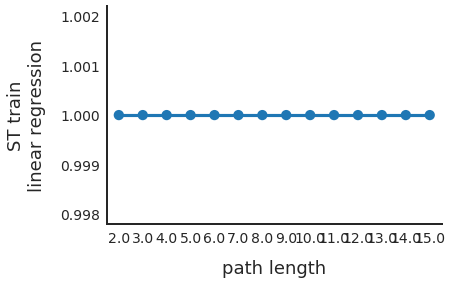

In [56]:
pathlenviolin(trainST, "ST train\nlinear regression", False)
pathlenmeanplt(trainST, "ST train\nlinear regression", False)

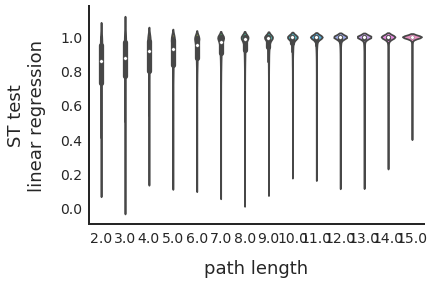

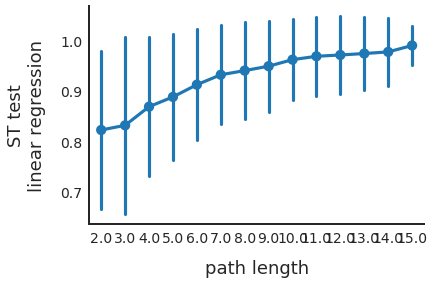

In [57]:
pathlenviolin(testST, "ST test\nlinear regression", False)
pathlenmeanplt(testST, "ST test\nlinear regression", False)

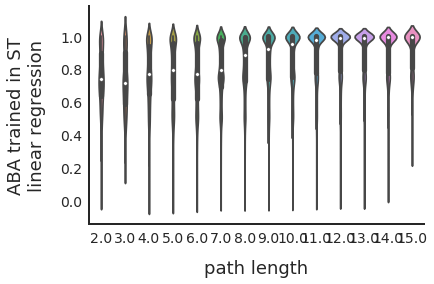

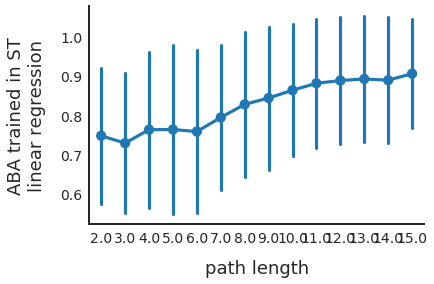

In [62]:
pathlenviolin(allABA, "ABA trained in ST\nlinear regression", False)
pathlenmeanplt(allABA, "ABA trained in ST\nlinear regression", "062220_8.pdf")

Explore inidvidual brain areas as examples

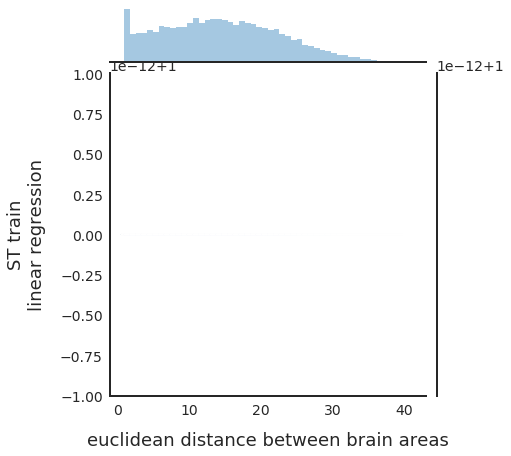

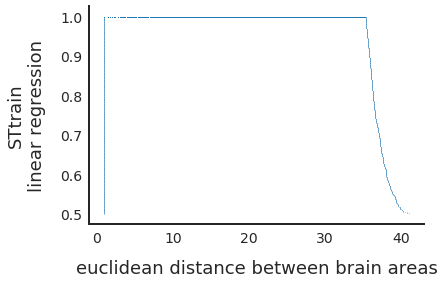

In [59]:
physdistplt(trainST, "ST train\nlinear regression", False)
convphysdistplt(trainST, "STtrain\nlinear regression", False)

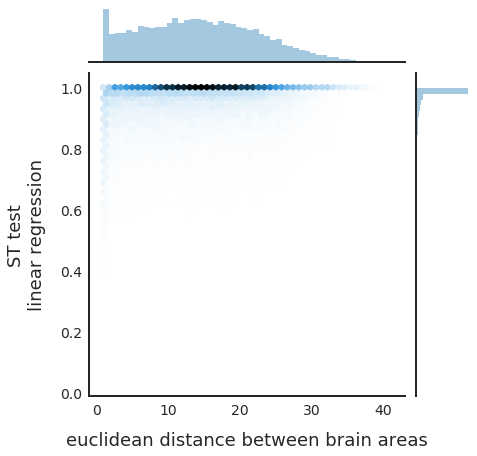

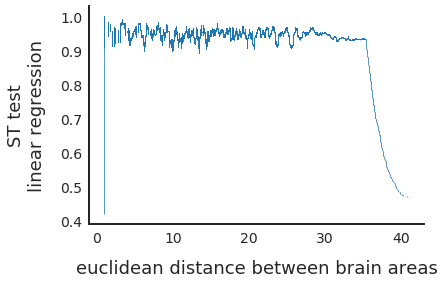

In [60]:
physdistplt(testST, "ST test\nlinear regression", False)
convphysdistplt(testST, "ST test\nlinear regression", False)

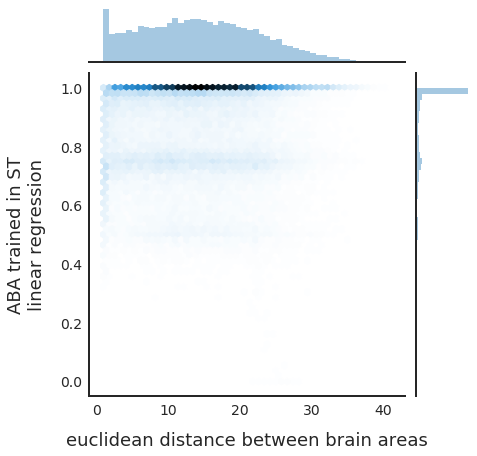

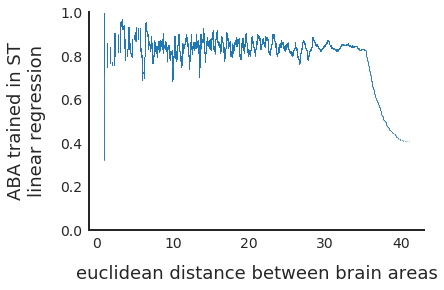

0


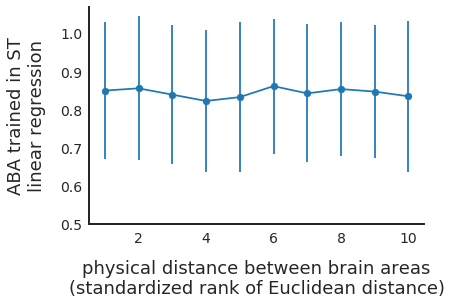

In [70]:
physdistplt(allABA, "ABA trained in ST\nlinear regression", False)
convphysdistplt(allABA, "ABA trained in ST\nlinear regression", False)
binnedphysdistplt(allABA, "ABA trained in ST\nlinear regression", 10, "080420_3.pdf")

# ABA to ST LASSO alpha = 0.1

In [71]:
ABATRAIN_FILE = "/home/slu/spatial/data/cross_lasso/ABAtoST_ABAtrain_f1_0p1_051420.csv"
ABATEST_FILE = "/home/slu/spatial/data/cross_lasso/ABAtoST_ABAtest_f1_0p1_051420.csv"
STALL_FILE = "/home/slu/spatial/data/cross_lasso/ABAtoST_STall_f1_0p1_051420.csv"

In [72]:
trainABA = pd.read_csv(ABATRAIN_FILE, sep=',')
trainABA = trainABA.set_index(trainABA.columns)

testABA = pd.read_csv(ABATEST_FILE, sep=',')
testABA = testST.set_index(testABA.columns)

allST = pd.read_csv(STALL_FILE, sep=',')
allST = allST.set_index(allST.columns)

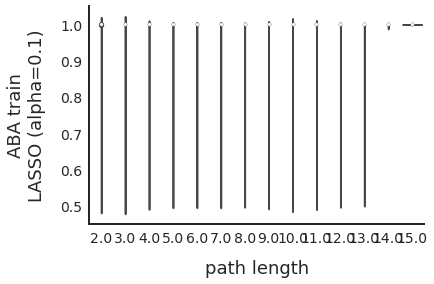

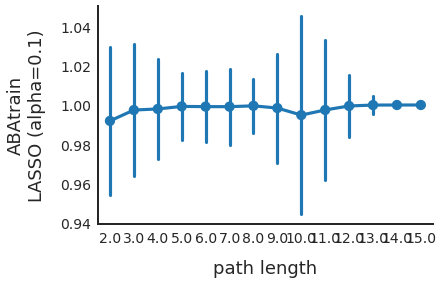

In [56]:
pathlenviolin(trainABA, "ABA train\nLASSO (alpha=0.1)", False)
pathlenmeanplt(trainABA, "ABAtrain\nLASSO (alpha=0.1)", False)

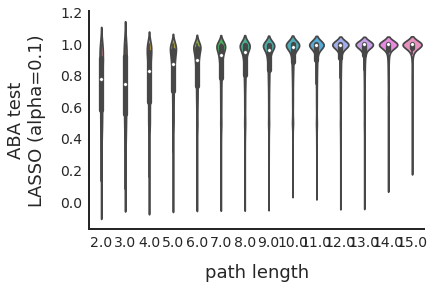

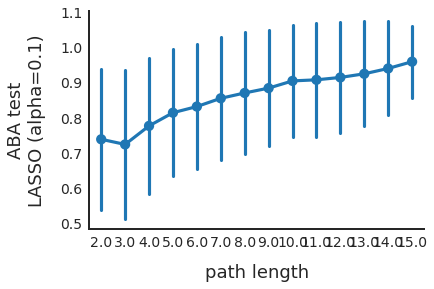

In [57]:
pathlenviolin(testABA, "ABA test\nLASSO (alpha=0.1)", False)
pathlenmeanplt(testABA, "ABA test\nLASSO (alpha=0.1)", False)

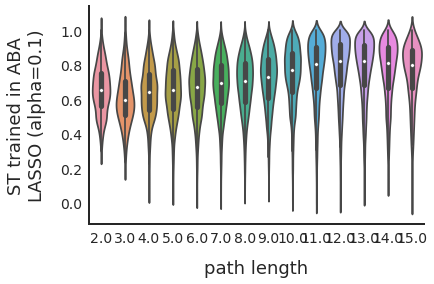

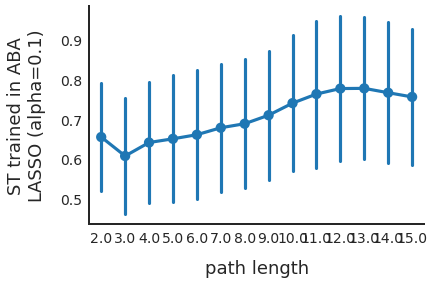

In [42]:
pathlenviolin(allST, "ST trained in ABA\nLASSO (alpha=0.1)", False)
pathlenmeanplt(allST, "ST trained in ABA\nLASSO (alpha=0.1)", "062220_4.pdf")

In [59]:
pathlen_upper = allpathlen.values[np.triu_indices_from(allpathlen.values, k=1)]
allST_upper = allST.values[np.triu_indices_from(allST.values, k=1)]

In [60]:
#calculate difference in means between shortest and longest path length
print(allST_upper[pathlen_upper==2].mean())
print(allST_upper[pathlen_upper==2].std())

0.6550391893244452
0.13686932809698113


In [61]:
print(allST_upper[pathlen_upper==np.max(pathlen_upper)].mean())
print(allST_upper[pathlen_upper==np.max(pathlen_upper)].std())

0.755955144778532
0.17103113947182688


In [62]:
#difference in means
allST_upper[pathlen_upper==np.max(pathlen_upper)].mean() - allST_upper[pathlen_upper==2].mean()

0.10091595545408683

Explore inidvidual brain areas as examples

In [167]:
filtareas = np.where(np.logical_and(allpathlen==2, allST<=0.5))
areasx = np.array(list(allST))[filtareas[0]]
areasy = np.array(list(allST))[filtareas[1]]

In [168]:
print(len(areasx))
print(len(areasy))

117
117


In [169]:
#convert areas to int for ontology indexing
areasx = [int(i) for i in areasx]
areasy = [int(i) for i in areasy]

In [170]:
#has to be done this way because need to preserve order of pairs
xnames = pd.DataFrame(columns=list(ontology))
ynames = pd.DataFrame(columns=list(ontology))
for i in range(len(areasx)):
    xnames = xnames.append(ontology.loc[ontology.id==areasx[i], :])
    ynames = ynames.append(ontology.loc[ontology.id==areasy[i], :])

In [171]:
xnames.to_csv("temp.csv")

In [172]:
ynames.to_csv("temp.csv")

__physical distance__

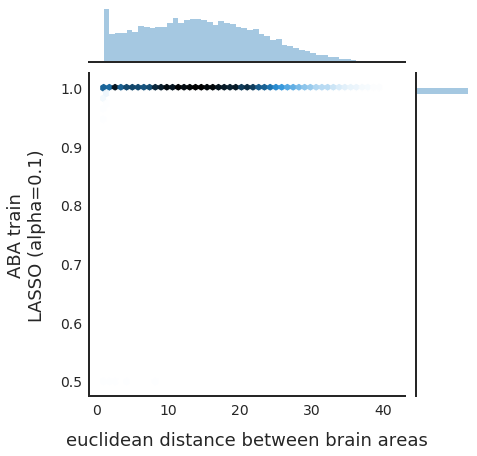

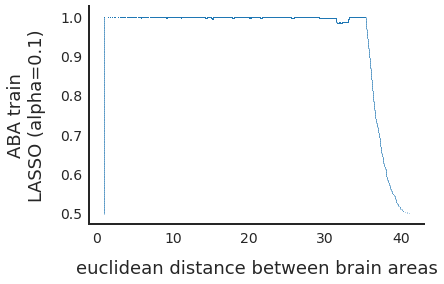

In [101]:
physdistplt(trainABA, "ABA train\nLASSO (alpha=0.1)", False)
convphysdistplt(trainABA, "ABA train\nLASSO (alpha=0.1)", False)

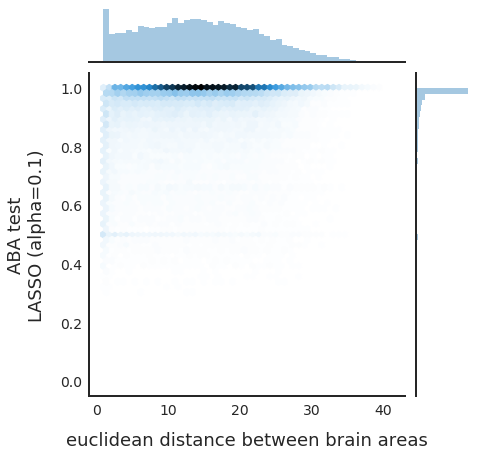

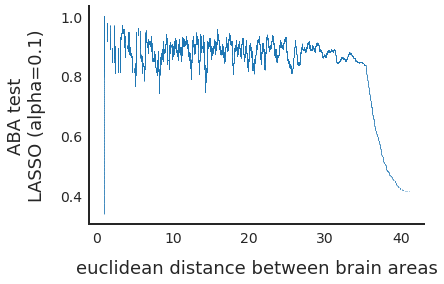

In [102]:
physdistplt(testABA, "ABA test\nLASSO (alpha=0.1)", False)
convphysdistplt(testABA, "ABA test\nLASSO (alpha=0.1)", False)

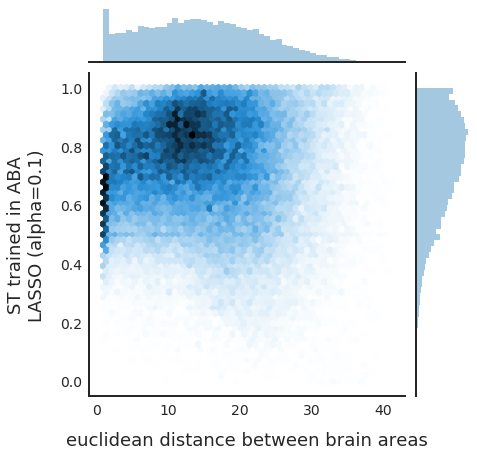

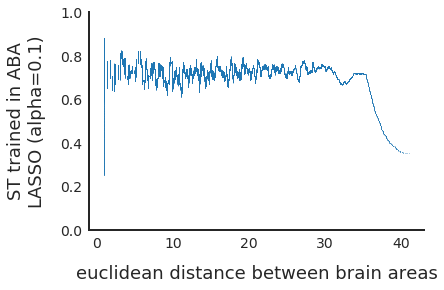

0


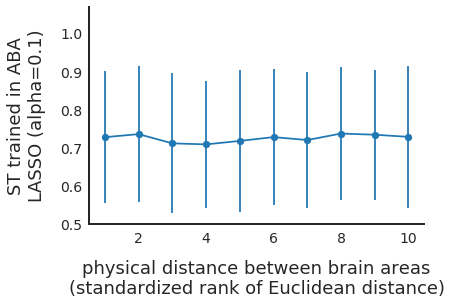

In [77]:
physdistplt(allST, "ST trained in ABA\nLASSO (alpha=0.1)", False)
convphysdistplt(allST, "ST trained in ABA\nLASSO (alpha=0.1)", False)
binnedphysdistplt(allST, "ST trained in ABA\nLASSO (alpha=0.1)", 10, False)

play around w/ binning euclidean distance to match path len

In [177]:
mindist = ABAdists.min().min() #1
maxdist = ABAdists.max().max() #41.012

In [185]:
allST.values[np.logical_and(ABAdists>=1, ABAdists<2)].mean()

0.6509773162513809

In [186]:
allST.values[np.logical_and(ABAdists>maxdist-1, ABAdists<=maxdist)].mean()

0.6970806699406084

In [187]:
ABAdists_upper = ABAdists.values[np.triu_indices_from(ABAdists.values, k=1)]
allST_upper = allST.values[np.triu_indices_from(allST.values, k=1)]

In [190]:
sp.stats.pearsonr(ABAdists_upper,allST_upper)

(-0.026334612131264108, 1.2470477084415553e-16)

# ABA to ST LASSO alpha = 0.05

In [78]:
ABATRAIN_FILE = "/home/slu/spatial/data/cross_lasso/ABAtoST_ABAtrain_f1_0p05_051720.csv"
ABATEST_FILE = "/home/slu/spatial/data/cross_lasso/ABAtoST_ABAtest_f1_0p05_051720.csv"
STALL_FILE = "/home/slu/spatial/data/cross_lasso/ABAtoST_STall_f1_0p05_051720.csv"

In [79]:
trainABA = pd.read_csv(ABATRAIN_FILE, sep=',')
trainABA = trainABA.set_index(trainABA.columns)

testABA = pd.read_csv(ABATEST_FILE, sep=',')
testABA = testST.set_index(testABA.columns)

allST = pd.read_csv(STALL_FILE, sep=',')
allST = allST.set_index(allST.columns)

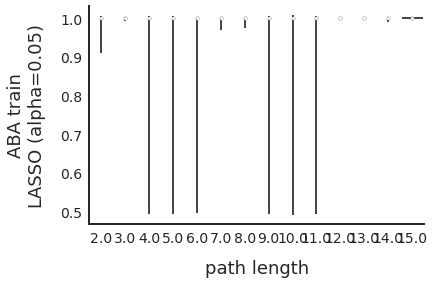

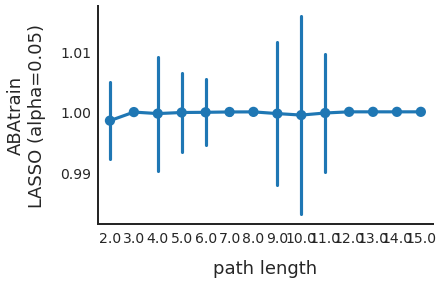

In [68]:
pathlenviolin(trainABA, "ABA train\nLASSO (alpha=0.05)", False)
pathlenmeanplt(trainABA, "ABAtrain\nLASSO (alpha=0.05)", False)

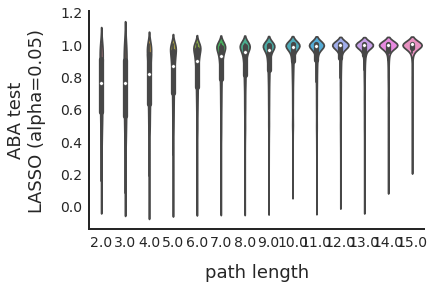

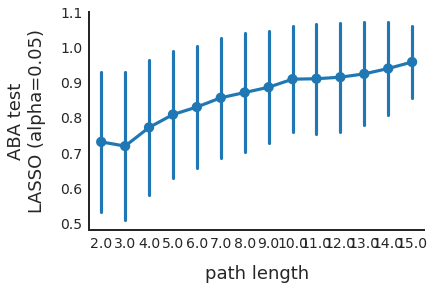

In [69]:
pathlenviolin(testABA, "ABA test\nLASSO (alpha=0.05)", False)
pathlenmeanplt(testABA, "ABA test\nLASSO (alpha=0.05)", False)

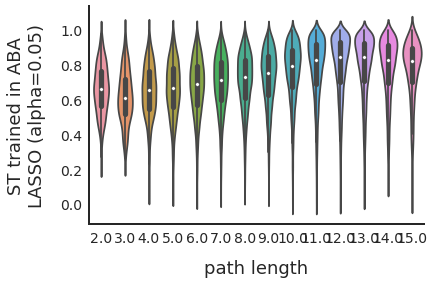

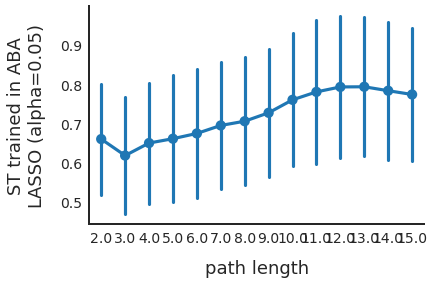

In [70]:
pathlenviolin(allST, "ST trained in ABA\nLASSO (alpha=0.05)", False)
pathlenmeanplt(allST, "ST trained in ABA\nLASSO (alpha=0.05)", "062220_11.pdf")

Explore inidvidual brain areas as examples

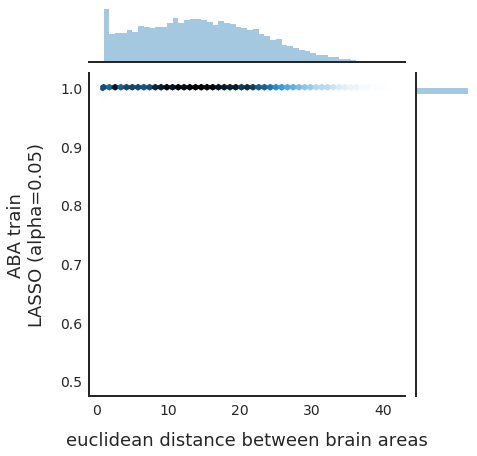

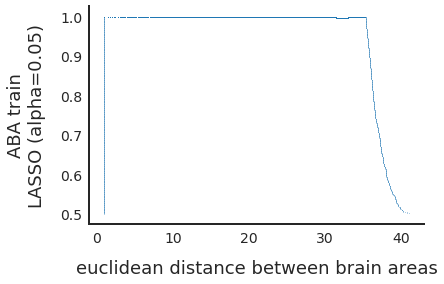

In [71]:
physdistplt(trainABA, "ABA train\nLASSO (alpha=0.05)", False)
convphysdistplt(trainABA, "ABA train\nLASSO (alpha=0.05)", False)

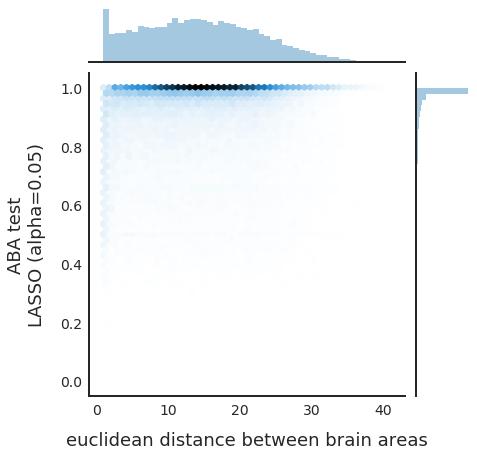

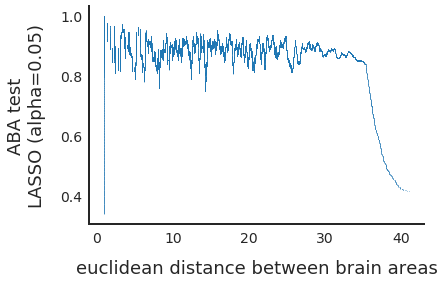

In [72]:
physdistplt(testABA, "ABA test\nLASSO (alpha=0.05)", False)
convphysdistplt(testABA, "ABA test\nLASSO (alpha=0.05)", False)

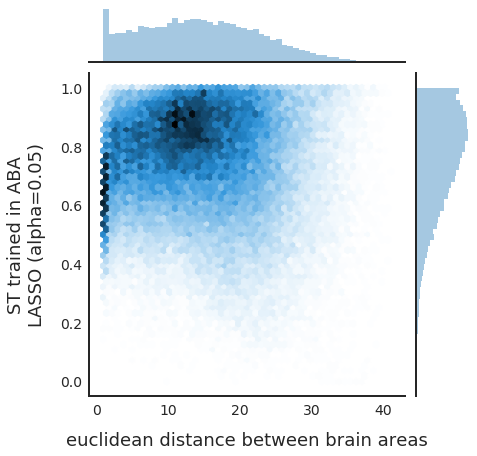

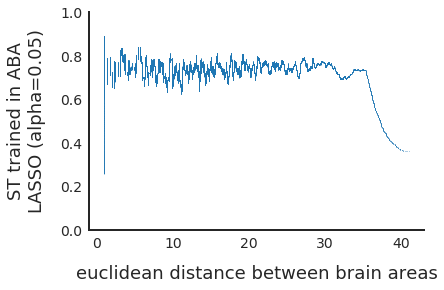

0


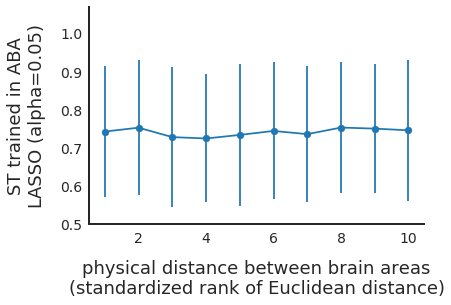

In [81]:
physdistplt(allST, "ST trained in ABA\nLASSO (alpha=0.05)", False)
convphysdistplt(allST, "ST trained in ABA\nLASSO (alpha=0.05)", False)
binnedphysdistplt(allST, "ST trained in ABA\nLASSO (alpha=0.05)", 10, "080420_5.pdf")

# ABA to ST linear regression (alpha = 0)

In [82]:
ABATRAIN_FILE = "/home/slu/spatial/data/cross_lasso/ABAtoST_ABAtrain_f1_0_051520.csv"
ABATEST_FILE = "/home/slu/spatial/data/cross_lasso/ABAtoST_ABAtest_f1_0_051520.csv"
STALL_FILE = "/home/slu/spatial/data/cross_lasso/ABAtoST_STall_f1_0_051520.csv"

In [83]:
trainABA = pd.read_csv(ABATRAIN_FILE, sep=',')
trainABA = trainABA.set_index(trainABA.columns)

testABA = pd.read_csv(ABATEST_FILE, sep=',')
testABA = testST.set_index(testABA.columns)

allST = pd.read_csv(STALL_FILE, sep=',')
allST = allST.set_index(allST.columns)

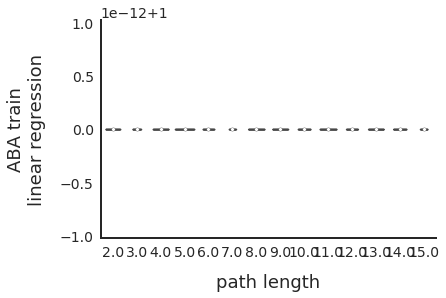

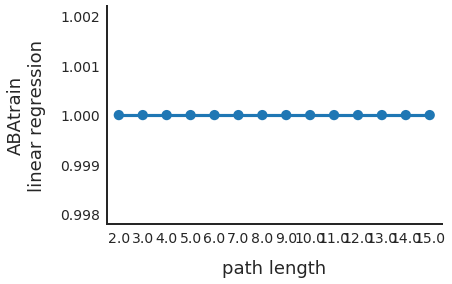

In [76]:
pathlenviolin(trainABA, "ABA train\nlinear regression", False)
pathlenmeanplt(trainABA, "ABAtrain\nlinear regression", False)

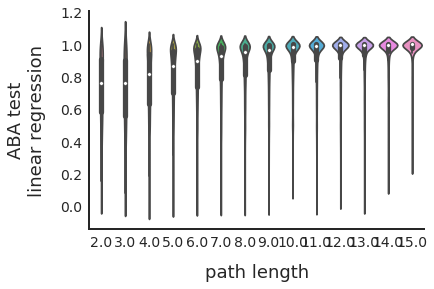

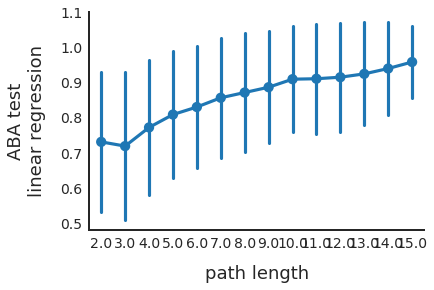

In [77]:
pathlenviolin(testABA, "ABA test\nlinear regression", False)
pathlenmeanplt(testABA, "ABA test\nlinear regression", False)

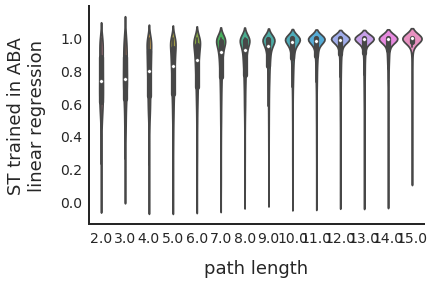

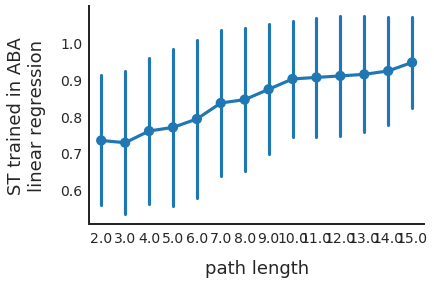

In [78]:
pathlenviolin(allST, "ST trained in ABA\nlinear regression", False)
pathlenmeanplt(allST, "ST trained in ABA\nlinear regression", "062220_14.pdf")

Explore inidvidual brain areas as examples

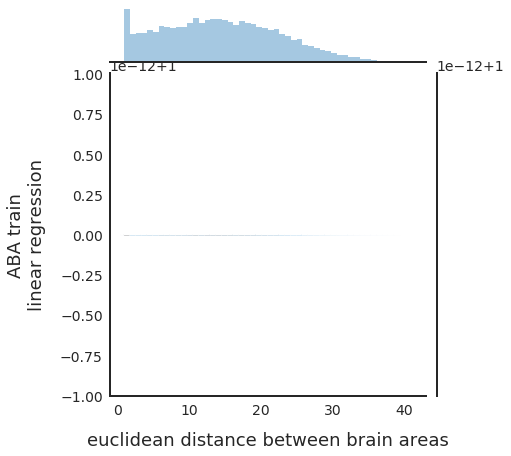

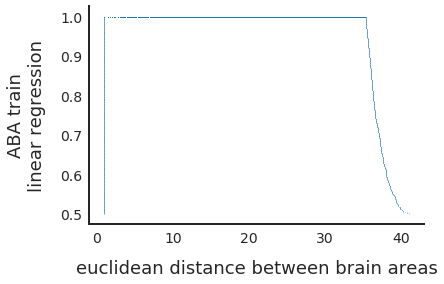

In [80]:
physdistplt(trainABA, "ABA train\nlinear regression", False)
convphysdistplt(trainABA, "ABA train\nlinear regression", False)

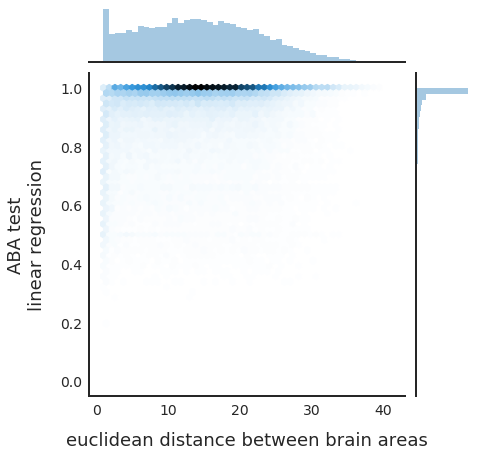

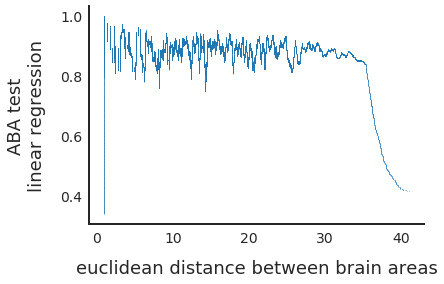

In [81]:
physdistplt(testABA, "ABA test\nlinear regression", False)
convphysdistplt(testABA, "ABA test\nlinear regression", False)

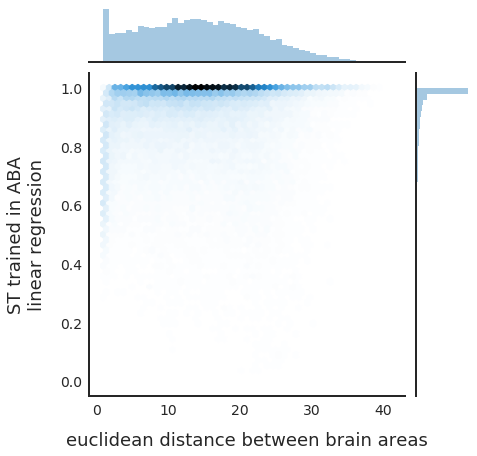

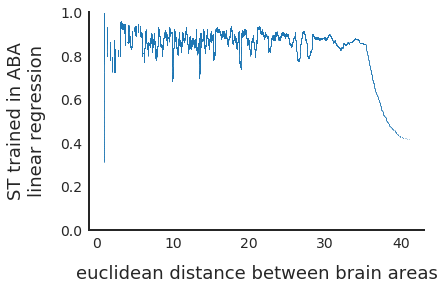

0


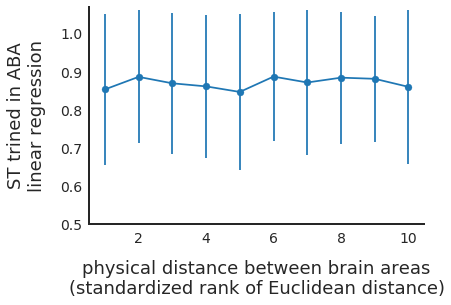

In [85]:
physdistplt(allST, "ST trained in ABA\nlinear regression", False)
convphysdistplt(allST, "ST trained in ABA\nlinear regression", False)
binnedphysdistplt(allST, "ST trined in ABA\nlinear regression", 10, "080420_6.pdf")

TO DO:
- explore individual brain areas at extremes
- correlation for euclidean
- determine difference in median auroc b/t shortest and largest path length
- plots for other cross aurocs (diff. alpha) -> done